In [1]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from vis.visualization import visualize_cam, visualize_saliency, visualize_activation
import cv2

import sys
sys.path
sys.path.append("/Users/lindronics/workspace/4th_year/honours_project/models/classification")

from models import ResNet, AlexNet
from dataset import Dataset

Using TensorFlow backend.


In [2]:
TRAIN_PATH = "/Users/lindronics/workspace/4th_year/honours_project_data/main/train.txt"
VAL_PATH = "/Users/lindronics/workspace/4th_year/honours_project_data/main/test.txt"
WEIGHTS_PATH = "/Users/lindronics/workspace/4th_year/out/AlexNet_rgb_weights.h5"

In [3]:
train_data = Dataset(TRAIN_PATH, res=(120, 160))
val_data = Dataset(VAL_PATH, res=(120, 160))
data = train_data

## Load model

In [4]:
model = AlexNet("rgb", data.num_classes(), data.shape()).get_model()

In [5]:
model.load_weights(WEIGHTS_PATH)

In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

## Test prediction

In [7]:
X, y = data[0]
y = np.argmax(y, axis=1)

In [8]:
y_pred = np.argmax(model.predict(X), axis=1)

In [9]:
print(np.vstack([y, y_pred]))

[[3 1 5 3 1 0 1 1 4 5 6 3 1 5 1 7]
 [3 1 5 3 1 0 1 1 4 5 6 3 1 5 1 7]]


## Kernels

In [10]:
layer_dict

{'input_1': <tensorflow.python.keras.engine.input_layer.InputLayer at 0x155ebacd0>,
 'tf_op_layer_strided_slice': <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer at 0x15604f5d0>,
 'conv2d': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1102694d0>,
 'max_pooling2d': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x155f76a90>,
 'conv2d_1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x156075b90>,
 'max_pooling2d_1': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x1560add50>,
 'conv2d_2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1560c1c90>,
 'conv2d_3': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1560caa90>,
 'conv2d_4': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1567eed10>,
 'max_pooling2d_2': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x1567f4450>,
 'flatten': <tensorflow.python.keras.layers.core.Flatten at 0x156806b50>,
 'dense': <tensorflow.python.keras.layers.core.Dense 

In [31]:
def plot_kernels(w, padding=1, color=False):
    print(w.shape)
    w = (w - np.min(w)) / (np.max(w)-np.min(w))
    
    ksize = w.shape[:2]
    channels = 3 if w.shape[2] == 3 and color else 1
    filters = w.shape[3]
    
    length = int(np.sqrt(filters))
    
    rows = []
    for i in range(length):
        row = []
        for j in range(length):
            row.append(w[..., :channels, length*i+j])
            row.append(np.ones((ksize[1], padding, channels)))
        row = np.hstack(row)
        rows.append(row)
        rows.append(np.ones((padding, row.shape[1], channels)))
    final = np.vstack(rows)
    final = final[:-padding, :-padding]
    
    if channels == 1:
        final = final[..., 0]
    
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(final, cmap="gray")
    ax.axis('off')

(11, 11, 3, 96)


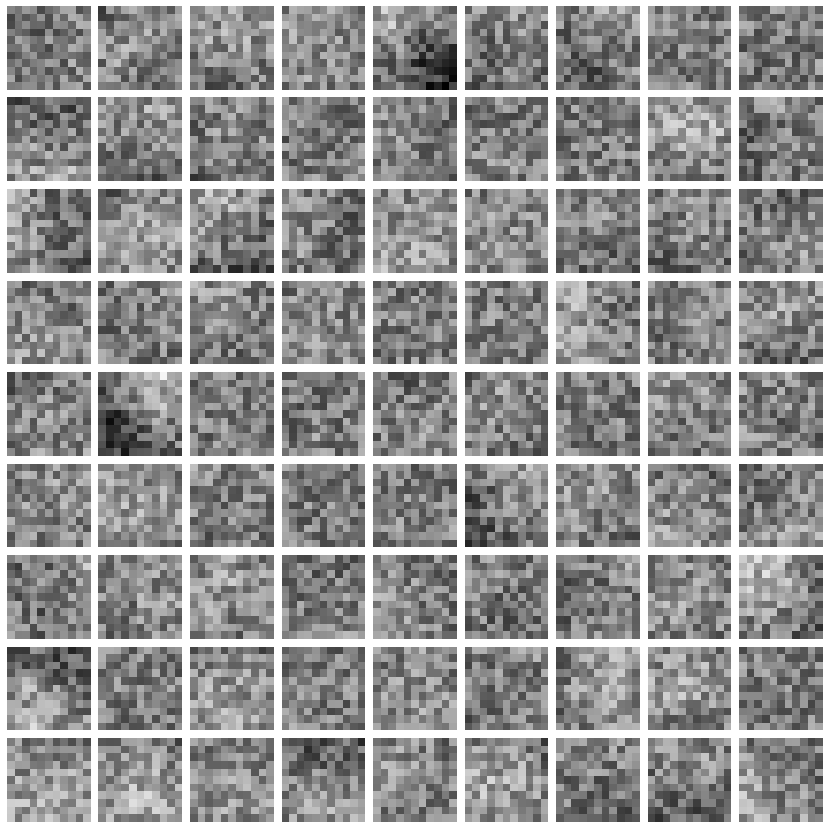

In [32]:
weights = model.get_layer("conv2d").weights[0].numpy()
plot_kernels(weights, padding=1, color=False)

## t-SNE class visualisation

In [4]:
# WEIGHTS_PATH = "/Users/lindronics/workspace/4th_year/out/ResNet_rgb_weights.h5"
# model = ResNet("rgb", train_data.num_classes(), train_data.shape()).get_model()

WEIGHTS_PATH = "/Users/lindronics/workspace/4th_year/out/stratified/weights.h5"
model = ResNet("fusion", train_data.num_classes(), train_data.shape()).get_model()

model.load_weights(WEIGHTS_PATH)
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [17]:
list(enumerate(layer_dict))

[(0, 'input_1'),
 (1, 'tf_op_layer_strided_slice'),
 (2, 'tf_op_layer_strided_slice_1'),
 (3, 'conv2d'),
 (4, 'conv2d_14'),
 (5, 'max_pooling2d'),
 (6, 'max_pooling2d_2'),
 (7, 'conv2d_1'),
 (8, 'conv2d_15'),
 (9, 'batch_normalization'),
 (10, 'batch_normalization_12'),
 (11, 're_lu'),
 (12, 're_lu_12'),
 (13, 'conv2d_2'),
 (14, 'conv2d_16'),
 (15, 'batch_normalization_1'),
 (16, 'batch_normalization_13'),
 (17, 'add'),
 (18, 'add_6'),
 (19, 're_lu_1'),
 (20, 're_lu_13'),
 (21, 'conv2d_3'),
 (22, 'conv2d_17'),
 (23, 'batch_normalization_2'),
 (24, 'batch_normalization_14'),
 (25, 're_lu_2'),
 (26, 're_lu_14'),
 (27, 'conv2d_4'),
 (28, 'conv2d_18'),
 (29, 'batch_normalization_3'),
 (30, 'batch_normalization_15'),
 (31, 'add_1'),
 (32, 'add_7'),
 (33, 're_lu_3'),
 (34, 're_lu_15'),
 (35, 'conv2d_5'),
 (36, 'conv2d_19'),
 (37, 'batch_normalization_4'),
 (38, 'batch_normalization_16'),
 (39, 're_lu_4'),
 (40, 're_lu_16'),
 (41, 'conv2d_6'),
 (42, 'conv2d_20'),
 (43, 'batch_normalization_5'

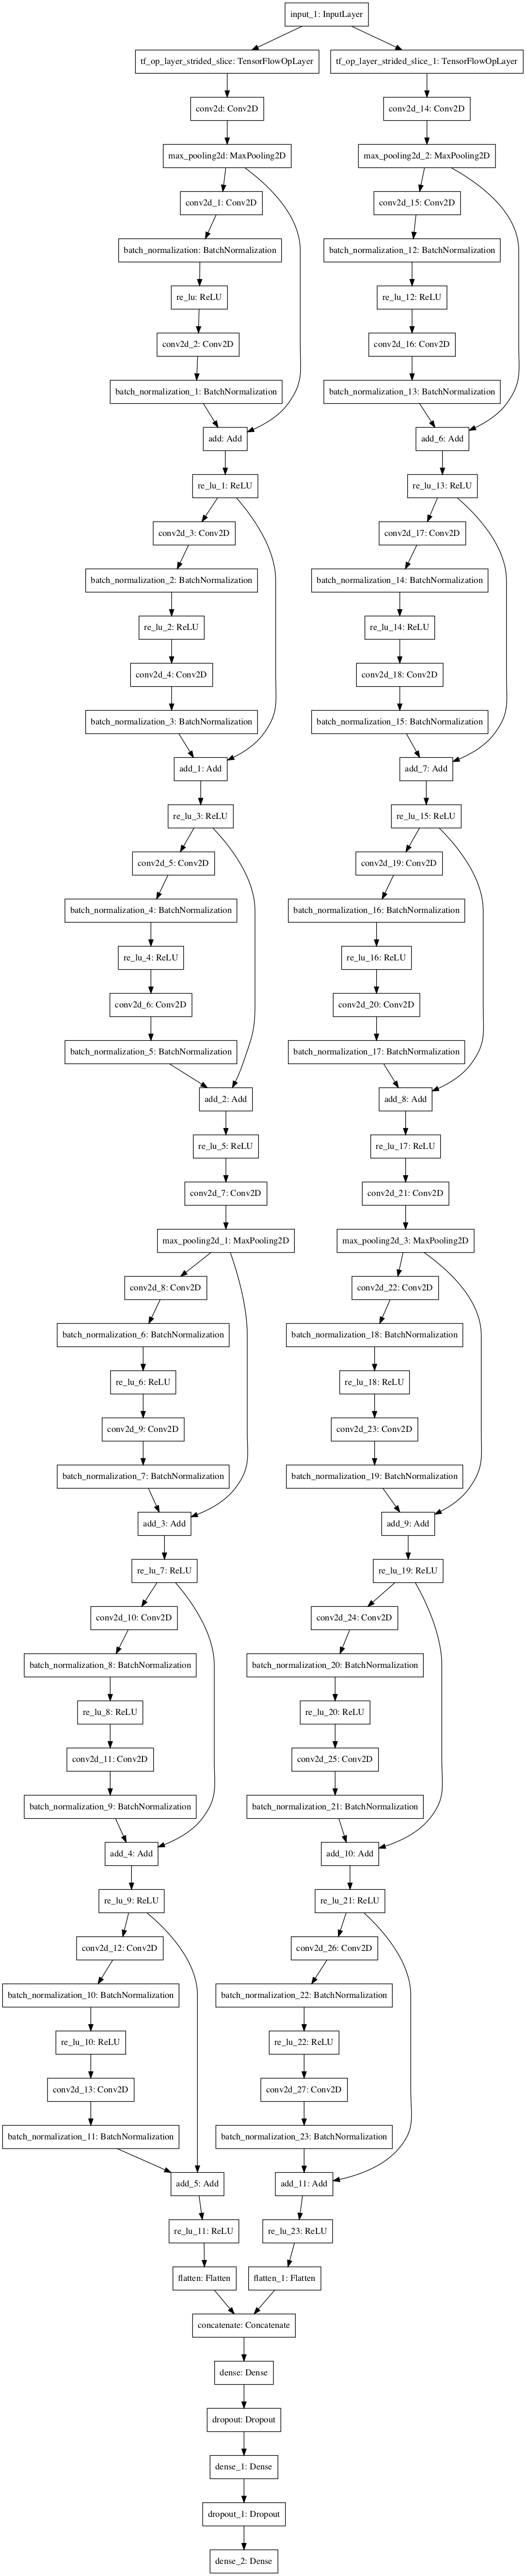

In [19]:
K.utils.plot_model(model)#, to_file="asdf.png")

In [6]:
def get_layer_output(model, layer, x):
    fn = K.backend.function([model.layers[0].input],
                            [layer_dict[layer].output])
    return fn([x])[0]

def plot_embedding(x, y):
    _, ax = plt.subplots(1, figsize=(6, 6), dpi=150)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    cm = plt.cm.get_cmap("Set1")
    f = plt.figure(figsize=(13, 13))
    for cname, clabel in data.classes.items():  
        x_0 = x[:, 0][y == clabel]
        x_1 = x[:, 1][y == clabel]
        y_class = y[y == clabel]
        sc = ax.scatter(x_0, x_1, lw=0, s=90, cmap=cm, label=cname, alpha=0.7)
    ax.axis("off")
    ax.axis("tight")
    ax.legend()
    
def evaluate_layer(model, layer, X_, y_):
    X_conv = get_layer_output(model, layer, X_)
    y_embeddings = TSNE(n_components=2, init="pca", random_state=0).fit_transform(X_conv.reshape(X_conv.shape[0], -1))
    plot_embedding(y_embeddings, np.argmax(y_, axis=1))

In [7]:
X, y = train_data.get_all()
# X = X[:400]
# y = y[:400]

In [8]:
X.shape

(1808, 160, 120, 4)

In [9]:
%%time
y_embeddings = TSNE(n_components=2, init="pca", random_state=0).fit_transform(X.reshape(X.shape[0], -1))
# plot_embedding(y_embeddings, np.argmax(y, axis=1))

CPU times: user 6min 43s, sys: 3.67 s, total: 6min 46s
Wall time: 6min 36s


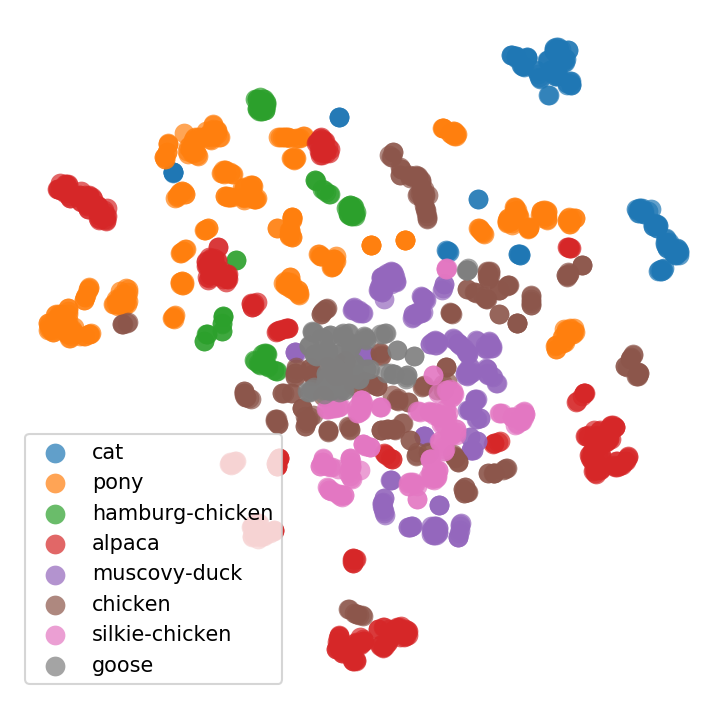

<Figure size 936x936 with 0 Axes>

In [38]:
plot_embedding(y_embeddings, np.argmax(y, axis=1))

In [31]:
%%time
# evaluate_layer(model, "conv2d", X, y)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs


In [32]:
%%time
# evaluate_layer(model, "conv2d_8", X, y)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs


CPU times: user 1min 2s, sys: 4.75 s, total: 1min 7s
Wall time: 25.8 s


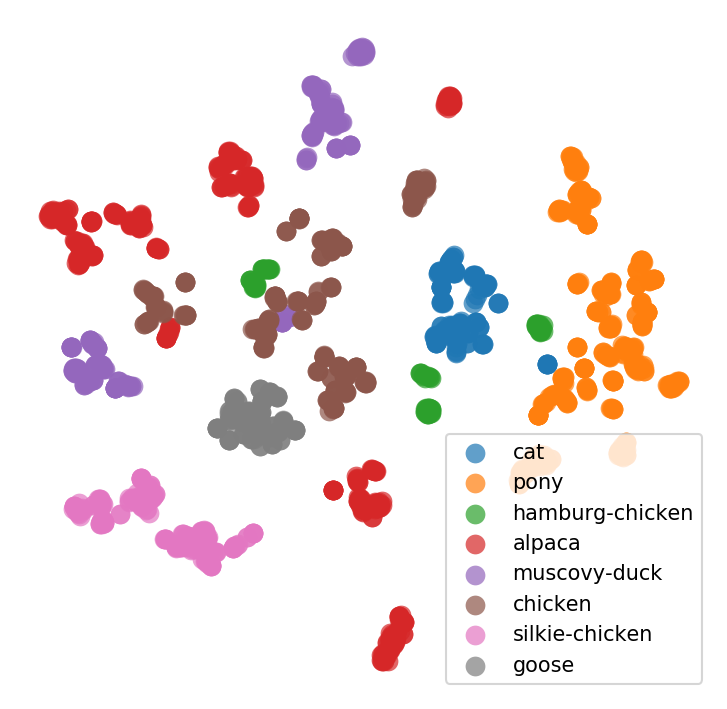

<Figure size 936x936 with 0 Axes>

In [39]:
%%time
evaluate_layer(model, "conv2d_13", X, y)

## Outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


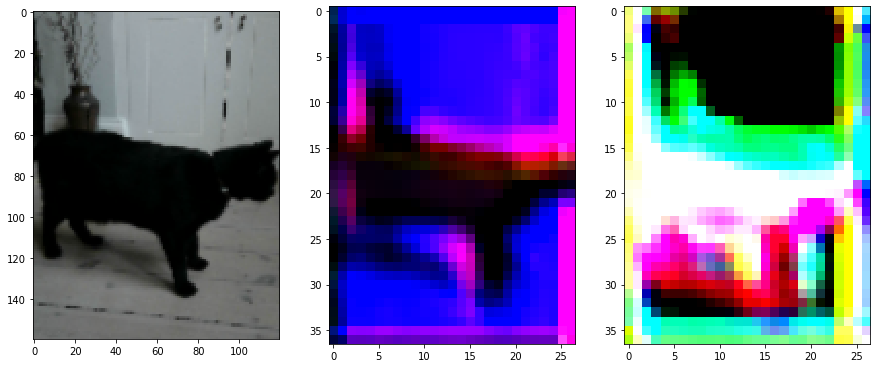

In [57]:
img = 5
ch = 0

fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(X[img, ..., :3])
ax[1].imshow(get_layer_output(model, "conv2d_1", X[img:img+1])[0, ..., ch:ch+3])
ax[2].imshow(get_layer_output(model, "conv2d_2", X[img:img+1])[0, ..., ch:ch+3])

## Saliency map

asd
asd
asd
asd
asd


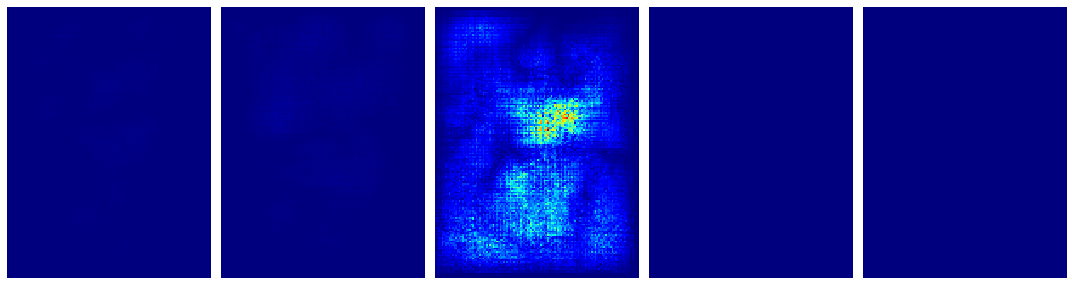

In [94]:
def saliency(X_img, y_img, model, layer=-1):
    saliency_map = visualize_saliency(model, layer, np.argmax(y_img), X_img).astype(np.float32) / 255
    return saliency_map
    
n = 5
ids = np.random.randint(0, X.shape[0], n)

fig, axes = plt.subplots(1, n, figsize=(15, 10))
for i, ax in zip(ids, axes):
    output_image = saliency(X[i][None, ...], y[i], model)
    ax.imshow(output_image, cmap="jet")
    ax.axis("off")
fig.tight_layout()

## Class activation heat maps

[1297  387  600  315   13]


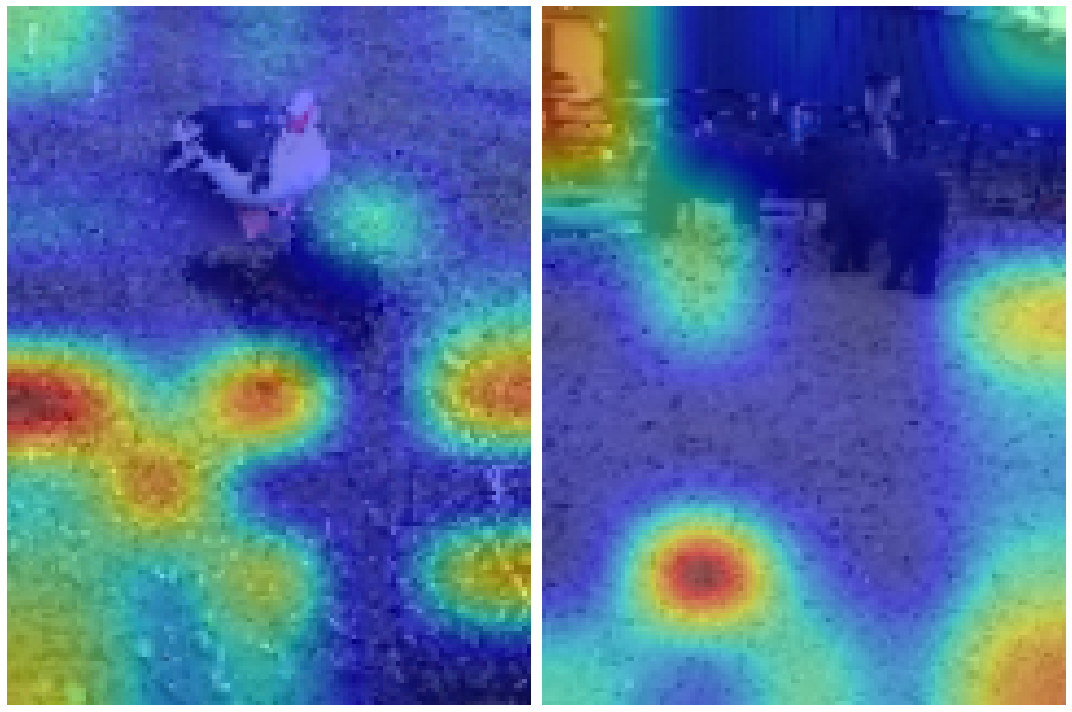

In [26]:
def heatmap(X_img, y_img, model, layer=-1, penultimate=44):
    heat_map = visualize_cam(model, layer, np.argmax(y_img), X_img, penultimate_layer_idx=penultimate).astype(np.float32) / 255
    output_image = cv2.addWeighted(X_img[0, ..., :3], 0.5, heat_map, 0.5, 0)
    return output_image
    
n = 5
ids = np.random.randint(0, X.shape[0], n)
print(ids)

n = 2
ids = [957, 646]

fig, axes = plt.subplots(1, n, figsize=(15, 10))
for i, ax in zip(ids, axes):
    output_image = heatmap(X[i][None, ...], y[i], model, penultimate=87)
    ax.imshow(output_image)
    ax.axis("off")
fig.tight_layout()

## Activation visualisation

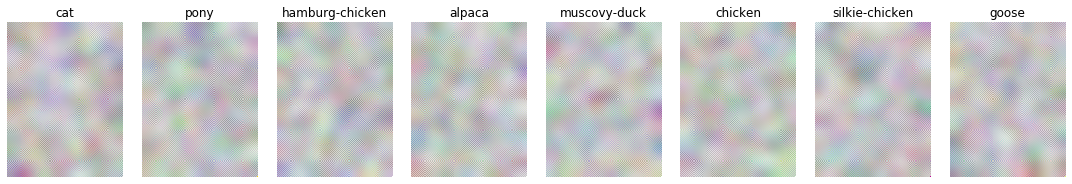

In [40]:
fig, axes = plt.subplots(1, data.num_classes(), figsize=(15, 10))
for i, ax in enumerate(axes):
    img = visualize_activation(model, -1, filter_indices=1, max_iter=100, verbose=False)
    ax.imshow(img)
    ax.set_title(data.class_dict[i])
    ax.axis("off")
fig.tight_layout()